# Проект: Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Фабула проекта

**Заказчик:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен»

**Данные:** информация о технических характеристиках, комплектации и ценах автомобилей

**Задачи проекта:** построить модель для определения стоимости автомобиля

**Дополнительные условия:** Заказчику важны критерии:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**План проекта:**
 * Шаг 1. Загрузить данные, путь к файлу: /datasets/autos.csv.
 * Шаг 2. Изучить данные. Заполнить пропущенные значения и обработать аномалии в столбцах. Удалить неинформативные признаки.
 * Шаг 3. Подготовить выборки для обучения моделей.
 * Шаг 4. Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробовать разные гиперпараметры.
 * Шаг 5. Проанализировать время обучения, время предсказания и качество моделей.
 * Шаг 6. Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.

**Примечания:**
 - Для оценки качества моделей применять метрику RMSE.
 - Значение метрики RMSE должно быть меньше 2500.
 - Самостоятельно освоить библиотеку LightGBM и её средствами построить модели градиентного бустинга.
 - Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найти её.
 - Модель градиентного бустинга может долго обучаться, поэтому изменить у неё только два-три параметра.
 - Если перестанет работать Jupyter Notebook, удалить лишние переменные оператором del ( del features_train ).

### Паспорт данных

**Описание данных:** Данные находятся в файле /datasets/autos.csv. Скачать датасет.

**Входные признаки:**
 * **DateCrawled** — дата скачивания анкеты из базы
 * **VehicleType** — тип автомобильного кузова
 * **RegistrationYear** — год регистрации автомобиля
 * **Gearbox** — тип коробки передач
 * **Power** — мощность (л. с.)
 * **Model** — модель автомобиля
 * **Kilometer** — пробег (км)
 * **RegistrationMonth** — месяц регистрации автомобиля
 * **FuelType** — тип топлива
 * **Brand** — марка автомобиля
 * **Repaired** — была машина в ремонте или нет
 * **DateCreated** — дата создания анкеты
 * **NumberOfPictures** — количество фотографий автомобиля
 * **PostalCode** — почтовый индекс владельца анкеты (пользователя)
 * **LastSeen** — дата последней активности пользователя

**Целевой признак:**
 * **Price** — цена (евро)

## Подготовка данных

### Импорт библиотек

In [ ]:
pip list # изучим перечень установленных библиотек

Package                           Version
--------------------------------- -------------------
absl-py                           1.2.0
alembic                           1.6.5
anyio                             3.2.1
argon2-cffi                       20.1.0
astunparse                        1.6.3
async-generator                   1.10
attrs                             21.2.0
Babel                             2.9.1
backcall                          0.2.0
backports.functools-lru-cache     1.6.4
beautifulsoup4                    4.9.3
bleach                            3.3.0
blinker                           1.4
blis                              0.7.8
branca                            0.5.0
brotlipy                          0.7.0
cachetools                        5.2.0
catalogue                         2.0.8
catboost                          1.0.3
certifi                           2022.6.15
certipy                           0.1.3
cffi                              1.14.5
chardet             

In [ ]:
!pip install phik -q # установим библиотеку phik

In [ ]:
# произведем импорт библиотек, необходимых для работы
import random
import re
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import phik
from phik import phik_matrix

from collections import Counter
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# зададим значение константы
RANDOM_STATE = 42

In [ ]:
# уберем максимальную ширину колонки
pd.set_option('display.max_colwidth', None)

### Загрузка данных

In [ ]:
# загрузим в датафрейм данные по автомобилям
pth1 = '/datasets/autos.csv'
pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'

if os.path.exists(pth1):
    data_autos = pd.read_csv(pth1)
else:
    try:
        response = requests.get(pth2)
        if response.status_code == 200:
            print("Запрос успешен. Загрузка данных...")
            data_autos = pd.read_csv(pth2)
        else:
            print(f"Ошибка: {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Ошибка при запросе: {e}")

### Изучение данных

In [ ]:
# используем ранее написанную функцию для изучения основной информации о датасетах
def data_info(data):
    display(data.info()) # вывод информации о датафрейме
    print('=' * 20)
    display(data.head()) # вывод верхнийх 5 строк датафрейма
    display(data.sample(10)) # вывод случайных 10 строк датафрейма
    display(data.tail()) # вывод нижних 5 строк датафрейма
    display(data.describe().T) # вывод статистических показателей числовых значений датафрейма
    print('Количество явных дубликатов: ', data.duplicated().sum()) # определение количества явных дубликатов строк
    print('Строки дубликаты:\n', data[data.duplicated()]) # вывод строк дубликатов, для их проверки
    print('=' * 20)
    print('Количество пропусков:\n', data.isna().sum()) # Вывод количества пропусков в датафрейме
    print('Доля пропусков в датафрейме:') # вывод информации о доле пропусков в датафрейме
    col = data.columns.tolist() # введем переменную со списком названий столбцов
    # циклом выведем долю пропусков в каждом столбце
    for a in col:
        print(f'В столбце {a} доля пропусков: {(data[a].isnull().sum() / len(data[a])*100).round(3)}%')
    print('=' * 20)
    print('Список уникальных значений в датафрейме:')
    # выведем список уникальных строковых значений для определения неявных дубликатов
    for b in data.select_dtypes('object').columns: # задаем поиск только по столбцам со строковыми данными
        print('Уникальные значения:')
        print(f'{b}: {data[b].unique()}')
        print('Количество уникальных значений:')
        print(f'{b}: {data[b].nunique()}')

In [ ]:
# с помощью написанной функции изучим загруженные данные
data_info(data_autos)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
19729,2016-03-31 20:36:24,2500,sedan,1995,manual,71,vectra,50000,5,petrol,opel,no,2016-03-31 00:00:00,0,33100,2016-04-06 16:45:37
276305,2016-03-05 23:36:17,16000,wagon,2011,auto,204,5er,125000,8,gasoline,bmw,no,2016-03-05 00:00:00,0,88326,2016-03-06 06:49:08
104960,2016-03-20 18:53:20,2500,small,1998,auto,136,clk,150000,7,petrol,mercedes_benz,no,2016-03-20 00:00:00,0,71336,2016-03-20 18:53:20
335871,2016-03-21 22:41:09,750,bus,2004,manual,0,carnival,150000,12,gasoline,kia,NaN,2016-03-21 00:00:00,0,36043,2016-04-07 02:46:36
257860,2016-04-02 14:51:17,900,wagon,1996,manual,98,other,150000,7,petrol,suzuki,no,2016-04-02 00:00:00,0,91356,2016-04-02 14:51:17
89229,2016-03-12 11:50:37,1425,sedan,2000,auto,197,e_klasse,150000,10,gasoline,mercedes_benz,no,2016-03-12 00:00:00,0,66113,2016-03-13 03:15:46
71049,2016-04-01 13:36:19,344,small,1994,manual,62,1_reihe,150000,7,NaN,peugeot,no,2016-04-01 00:00:00,0,94336,2016-04-07 11:17:43
266649,2016-03-07 07:57:47,600,sedan,1995,manual,140,3er,150000,3,petrol,bmw,yes,2016-03-07 00:00:00,0,86807,2016-03-07 16:17:50
329877,2016-03-09 10:53:55,3800,sedan,2001,manual,131,a4,150000,3,gasoline,audi,NaN,2016-03-09 00:00:00,0,24109,2016-03-20 01:17:29
138463,2016-03-19 14:45:46,1200,sedan,1996,auto,193,NaN,150000,12,petrol,bmw,NaN,2016-03-19 00:00:00,0,24768,2016-04-06 21:46:05


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Количество явных дубликатов:  4
Строки дубликаты:
                 DateCrawled  Price VehicleType  RegistrationYear Gearbox  \
171088  2016-03-08 18:42:48   1799       coupe              1999    auto   
231258  2016-03-28 00:56:10   1000       small              2002  manual   
258109  2016-04-03 09:01:15   4699       coupe              2003    auto   
325651  2016-03-18 18:46:15   1999       wagon              2001  manual   

        Power   Model  Kilometer  RegistrationMonth  FuelType          Brand  \
171088    193     clk      20000                  7    petrol  mercedes_benz   
231258     83   other     150000                  1    petrol         suzuki   
258109    218     clk     125000                  6    petrol  mercedes_benz   
325651    131  passat     150000                  7  gasoline     volkswagen   

       Repaired          DateCreated  NumberOfPictures  PostalCode  \
171088       no  2016-03-08 00:00:00                 0       89518   
231258       no  2016-03-28

При изучении данных наблюдаем следующее:
 - датафрейм состоит из 354368 строк и 16 колонок с признаками, из которых 15 признаков входный и 1 целевой
 - часть даннных имеет неверный формат:
     - DateCrawled необходимо перевести в формат даты
     - DateCreated необходимо перевести в формат даты
     - PostalCode, не смотря на числовые значения необходимо перевести в категориальный тип, поскольку это по факту идентификатор почтового отделения места нахождения и относится к специальному типу данных
     - LastSeen необходимо перевести в формат данных
 - названия столбцов, для удобства, необходимо будет привести к змеиной стилистике
 - численные даные распределены следующим образом:
     - Price - цена авто - имеет распределение от 0 до 20000. 0-е значения явно являются аномальными, необходимо будет их привести в норму или очистить
     - RegistrationYear - год регистрации автомобиля - имеет распределение от 1000 до 9999, крайние значения явно являются аномальными, необходимо будет выявить все аномалии и привести в порядок.
     - Power - мощность двигателя в л.с. - имеет распределение от 0 до 20000. Снова крайние значения являются аномальными, необходимо будет их приводить в порядок.
     - Kilometer - пробег в километрах - имеет распределение от 5000 до 150000. Предварительно распределение выглядит нормальным
     - RegistrationMonth - месяц регистрации - имеет распределение от 0 до 12. 0-е значение явная аномалия.
     - NumberOfPictures - количество фотографий - имеет распределени от 0 до 0, то есть по сути бесполезный признак, так как все значения 0-е
 - датафрейм имеет 4 явных дубликата
 - часть признаков имеет существенное количество явных пропусков:
     - VehicleType - 37490 пропусков, что составляет 10.579% об ощего количества данных в столбце
     - Gearbox - 19833 пропусков, что составляет 5.597% об ощего количества данных в столбце
     - Model - 19705 пропусков, что составляет 5.561% об ощего количества данных в столбце
     - FuelType - 32895 пропусков, что составляет 9.283% об ощего количества данных в столбце
     - Repaired - 71154 пропусков, что составляет 20.079% об ощего количества данных в столбце
 - неявных пропусков в категориальных данных не выявлено
 - выявлены неявные дубликаты в указании модели - 'rangerover' и 'range_rover' - необходимо будет заменить на 'range_rover' и неявные дубликаты в указании типа топлива: 'petrol' и 'gasoline' - заменим на европейский стандрат 'petrol'.

#### Вывод по блоку

По итогу изучения данных можно сделать следующие выводы:
1. В целом, из перечня входных признаков, видим большое количество откровенно мусорных признаков, не влияющих и не способных оказать внияние на  целевой признак и обучение модели, даже в качестве косвенных признаков, так как они не относятся к характеристикам автомобиля, а являются характеристиками пользователя или его поведения. Прежде чем приводить в порядок данные, очистим датафрейм от этих признаков. К этим признакам можно отнести:
     - DateCrawled — дата скачивания анкеты из базы
     - По большому счету RegistrationYear — год регистрации автомобиля и RegistrationMonth — месяц регистрации автомобиля являются неинформативными признаками, так как имеет значение год выпуска автомобиля. К тому же мы не знаем какой год указан в качестве года регистрации: год первой регистрации автомобиля в госавтоинспекции или год последней регистрации, после последней сделки с автомобилем. Опираться на модели мы не можем, так как они имеют серийность и разное поколение, выпускаемые в разные годы. Этих данных у нас нет, поэтому месяц регистрации мы удалим как неинформативный признак, а год регистрации оставим. С учетом распределения дат, скорее всего под годом регистрации подразумевается год первой регистрации по сделкам, а значит его можно условно принять как год выпуска автомобиля.
     - DateCreated — дата создания анкеты
     - NumberOfPictures — количество фотографий автомобиля, тем более, что все значения в этом признаке 0-е
     - PostalCode — почтовый индекс владельца анкеты (пользователя) кажется неинформативным признаком, однако структура почтового индекса в России построена таким образом, что первые 3 цифры указывают на город проживания пользователя, и именно город проживания может оказывать прямое влияние на цену определенных автомобилей. Например японские и китайские модели в восточной части России дешевле. Другое дело, что в России почтовые индексы имеют шестизначныей код, а в нашем датафрейме значения или 4-х значные или 5-и значные. Можно было бы предположить что числовой формат "съел" первые 0 в значениях, как бывает в ИНН или ОГРН или иных похожих числовых кодах с использованием нумерации региона, однако в России почтовые индексы никогда не начинаются с 0. Значит мы имеем дело с анкетами или из США, или из Германии, или из Чехии, или из Украины. Однако в каждой стране своя особенность индексациии. Увы точно мы установить не можем, так что на данном этапе этот признак удалим, однако уточнение этой особенности у заказчика позволит в перспективе улучшить показатели модели за счет дополнительного признака.
     - LastSeen — дата последней активности пользователя

2. В остальных входных признаках видим большое количество пропусков, заполнять их будем индивидуально в зависимости от каждого признака: некоторые можем заполнить условными значениями, некоторые вполне определенными, а некоторые будем заполнять случайными или наиболее популярными.

3. Также во многих признаках имеются явно аномальные, ошибочные значения, их тоже необходимо изучить индивидуально, для определения тактики их предобработки.

4. По большому счету разделение на бренд и модель автомобиля необходимо для упрощения поиска, сам по себе бренд не влияет на цену автомобиля, кроме того, у некоторых брендов есть одинаковые названия моделей, при разных характеристиках, так что эти два признака объединим в один, так как именно пара бренд-модель указывает на конкретную модель автомобиля и влияет на его стоимость.

5. Явные дубликаты удалим, благо их всего 4, неявные дубликаты переименуем

<div class = "alert alert-warning">
вот тут есть неплохая статья по поводу особенностей индексации и адресации в разных странах https://habr.com/ru/articles/691088/

### Предобработка данных

Прежде чем приступим к предобработке, необходимо определиться с тактикой заполнения пропусков.  У нас во всех клонках уже имеется условное обозначение 'other' - фактически оно обозначается единичные и не популярные случая. Можно было бы ропуски заменить другим условным обозначением, указывающим на неизвестность значений, но в итоге мы получим две неопределенные категории. Эффективнее будет из объединить, поэтому все пропуски мы тоже заменим на категорию 'other':
 - В столбце VehicleType (Тип кузова) - сам тип кузова напрямую связан с моделью автомобиля, поэтому мы можем заполнить пропуски на основании уже имеющихся данных о типах кузова у имеющихся моделей. Если после этого все равно останутся пропуски их заменим на уже имеющееся условное значение 'other' - пользователь мог банально не знать тип кузова своего автомобиля, поэтому и оставил пропуск
 - Gearbox (Тип коробки передач). У одной и той же модели автомобиля могут быть разные модификации с разным типом коробки передач, поэтому пропуски заполним значением 'other' - опять же пользователь мог банально не знать как указать тип коробки передач
 - Model (Модель автомобиля). Поскольку по косвенным признакам мы модель определить не сможем, то заменим пропуски значением 'other' - часто встречаются объявления без указания модели
 - FuelType (Тип топлива) - в данном случае, вариантов типа топлива не так уж и много может быть, поэтому заполним наиболее популярными типом топлива для этих моделей авто
 - Repaired - была машина в ремонте или нет. В данном случае разумнее заполнить значениями 'no', так как если машина была в ремонте, то пользователи прямо это указывают, если же не была в ремонте, то им проще и не указывать 'yes'. Конечно, можно предположить, что отсутвтие отметки о ремонте было в результате попытки ввести в заблуждение, но это все равно что указать 'no'. Этим поведенческим паттерном и объясняется столь большое количество пропусков.

 **Шаг 1.** Удалим неинформативные и лишние признаки, оставив только информативные

Определим дату самого позднего скачивания анкеты из бызы, для установления верхнего ограничения по году регистрации автомобилей

In [ ]:
# переведем в формат даты данные о скачивании анкет
data_autos['DateCrawled'] = pd.to_datetime(data_autos['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
date_max = data_autos['DateCrawled'].max()
date_max

Timestamp('2016-04-07 14:36:58')

Видим, что последний раз анкета скачивалась в 2016 году, этим годом и ограничим далее верхний потолок дат регистрации автомобилей

In [ ]:
# удалим данные о неинформативных признаках
data_autos.drop(columns=['DateCrawled',
                         'DateCreated',
                         'RegistrationMonth',
                         'PostalCode',
                         'LastSeen',
                         'NumberOfPictures'],
                axis=1,
                inplace=True)

**Шаг 2.** Переименуем  'rangerover' в 'range_rover'а 'gasoline' в 'petrol'

In [ ]:
# заменим названия модели и типа топлива на корректные
data_autos.loc[data_autos['Model'] == 'rangerover', 'Model'] = 'range_rover'
data_autos.loc[data_autos['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

**Шаг 3.** Заполним пропуски в колонках Model, Gearbox и Repaired

У нас во всех колонках уже есть "неопределенная" категория - 'other'. Поэтому заменим значения в этих колонках именно на него - фактически это означает что в этой категории либо единичные и крайне редкие значения, либо те самые не определенные пользователем.

In [ ]:
# заполним пустые данные по моделям и типу коробки передач
data_autos[['Model', 'Gearbox']] = data_autos[['Model', 'Gearbox']].fillna('other')

In [ ]:
# пустые данные о ремонте заменим на "no"
data_autos['Repaired'] = data_autos['Repaired'].fillna('no')

**Шаг 4.** Заполним пропуски в колонке VehicleType

Для заполнения пропусков создадим список моделей, без 'other', так как в 'other' фактически могут быть разные модели и заполнять в ней пропуски популярными значениями нельзя

In [ ]:
# записываем список моделей
model_list = sorted(data_autos['Model'].unique().astype(str))
# очищаем список от значения other
model_list = [model_list for model_list in model_list if model_list not in ('other')]

Проверим на случайной модели автомобиля, корректность указания типа кузова к модели

In [ ]:
random_model = random.choice(model_list) # запись в переменную случайного значения из списка моделей
data_autos[data_autos['Model'] == random_model][['Brand', 'Model', 'VehicleType']] # вывод в виде таблицы

,Brand,Model,VehicleType
456,audi,a2,small
671,audi,a2,sedan
794,audi,a2,sedan
1105,audi,a2,small
1949,audi,a2,small
...,...,...,...
347237,audi,a2,small
349239,audi,a2,small
350291,audi,a2,small
351495,audi,a2,other


Видим, что на разных случайных моделях регулярные ошибки - для одной и той же модели могут быть указаны разные типы кузова, чего быть не должно. По хорошему надо исправить все ошибочные указания типа кузова на корректные, но поскольку работа учебная, то исправлять ошибочные указания не будем, для сохранения условий разнообразия, иначе вводные пропорции значений типа кузова будут изменены, что повлияет на результат. Так что просто просто заменим пропуски наиболее популярными значениями, тем более они и есть правильные.

In [ ]:
# запустим цикл для замены всех пропусков на популярные для каждой модели
for i in model_list:
    mask = data_autos['Model'] == i
    venicle_list = data_autos[data_autos['Model'] == i]['VehicleType']
    pop_model = Counter(venicle_list).most_common(1)[0][0]
    data_autos.loc[mask, 'VehicleType'] = data_autos.loc[mask, 'VehicleType'].fillna(pop_model)

Оставшиеся пропуски в колонке VehicleType заменим значением 'other'

In [ ]:
data_autos['VehicleType'] = data_autos['VehicleType'].fillna('other')

**Шаг 5.** Заполним пропуски в значениях FuelType

In [ ]:
# запустим цикл замены пропусков для каждого типа топлива
for i in model_list:
    mask = data_autos['Model'] == i
    fuel_list = data_autos[data_autos['Model'] == i]['FuelType']
    pop_fuel = Counter(fuel_list).most_common(1)[0][0]
    data_autos.loc[mask, 'FuelType'] = data_autos.loc[mask, 'FuelType'].fillna(pop_model)

Оставшиеся пропуски заменим на 'other'

In [ ]:
data_autos['FuelType'] = data_autos['FuelType'].fillna('other')

In [ ]:
# выведем итоговую информацию о датафрейме
data_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       354369 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           354369 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             354369 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          354369 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          354369 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Все пропуски заполнены можно приступать к следующим шагам.

**Шаг 6.** Объединим колонки 'Brand' и 'Model' в одну колонку 'model_auto'

In [ ]:
# введем новую колонку для объединенных значений
data_autos['model_auto'] = data_autos['Brand'] + '_' + data_autos['Model']
# удалим старые колонки
data_autos.drop(columns=['Brand',
                         'Model'],
                axis=1,
                inplace=True)

**Шаг 7.** Удаление дубликатов

In [ ]:
# выведем информацию о дубликатах
display(data_autos[data_autos.duplicated()])
print('Количество дубликатов: ', data_autos.duplicated().sum())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,FuelType,Repaired,model_auto
1017,500,small,1996,manual,45,70000,petrol,no,opel_corsa
1051,11890,bus,2011,manual,116,150000,petrol,no,ford_c_max
1117,950,small,1999,manual,60,150000,petrol,no,volkswagen_polo
1396,0,other,2000,other,0,150000,other,no,volvo_other
2169,0,coupe,2002,manual,129,150000,petrol,no,mercedes_benz_c_klasse
...,...,...,...,...,...,...,...,...,...
354352,6500,sedan,2003,auto,145,150000,petrol,no,mercedes_benz_e_klasse
354355,4400,sedan,2008,manual,105,150000,petrol,no,seat_leon
354358,1490,small,1998,manual,50,150000,petrol,no,volkswagen_lupo
354359,7900,sedan,2010,manual,140,150000,petrol,no,volkswagen_golf


Количество дубликатов:  53610


После заполнения пропусков у нас вместо 4 стало 52526 дубликатов - их все будем удалять, так как они помешают обучению

In [ ]:
# удалим дубликаты и обновим индексы
data_autos = data_autos.drop_duplicates()
data_autos = data_autos.reset_index(drop=True)

**Шаг 8.** Удалим явно аномальные и ошибочные значения в параметрах Price, RegistrationYear и Power

Прежде чем удалять аномалии, определим их границы
1. Для Price - цена авто - 0-е значения явно являются аномальными, необходимо будет от них избавиться, но и изучить явно низкие значения.
2. RegistrationYear - год регистрации автомобиля - имеет распределение от 1000 до 9999, крайние значения явно являются аномальными, необходимо будет проанализировать распределение для определения границ.
3. Power - мощность двигателя в л.с. - имеет распределение от 0 до 20000. Также необходимо изучить распределение, для определения границ.

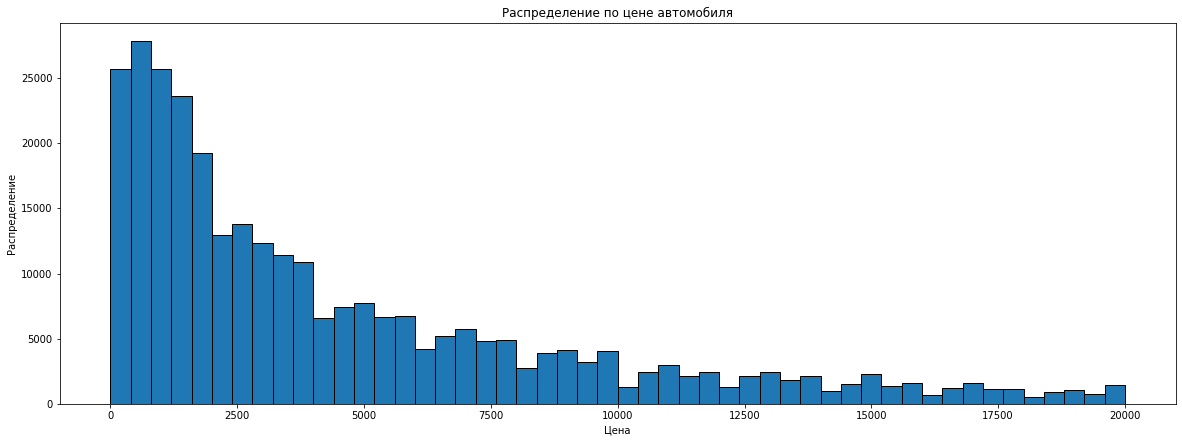

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Price'], bins=50, edgecolor='black')
plt.title('Распределение по цене автомобиля')
plt.xlabel('Цена')
plt.ylabel('Распределение')

plt.show()

Видим, что у нас очень высокая плотность распределения в значениях ниже 1000, ограничимся изучением этого диапазона

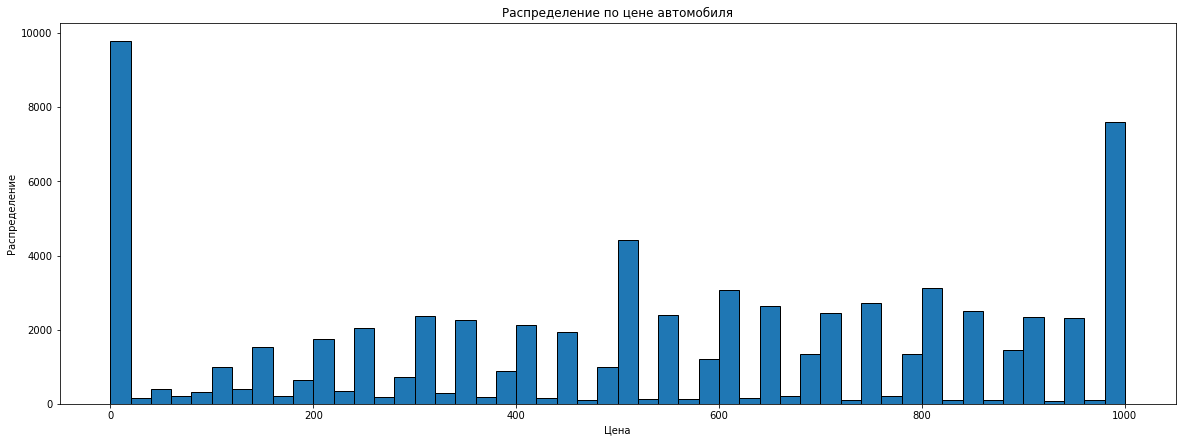

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Price'], bins=50, edgecolor='black', range=(0, 1000))
plt.title('Распределение по цене автомобиля')
plt.xlabel('Цена')
plt.ylabel('Распределение')

plt.show()

Видим, что ценовая категория от 0 до 50 евро состоявляет довольно большой процент в этом диапазоне, уменьшим масштаб наблюдения до 200

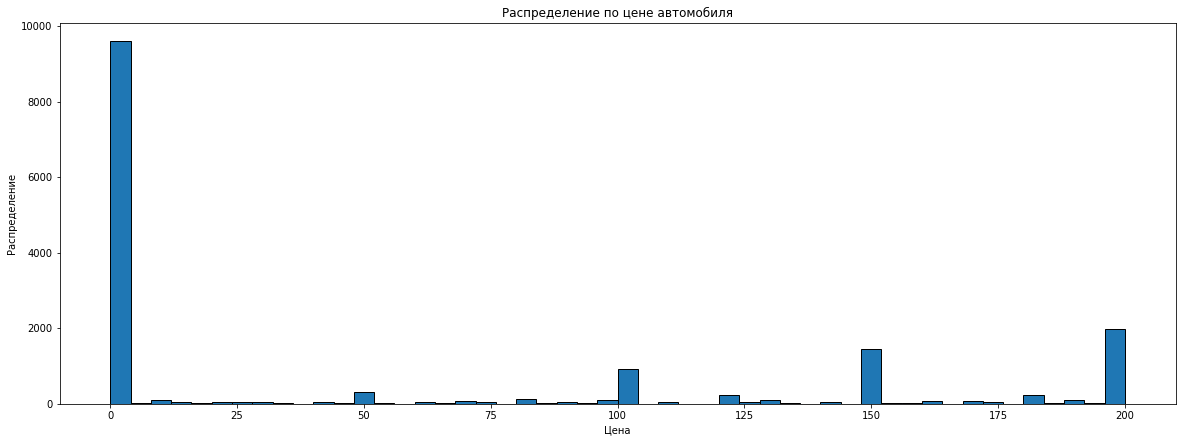

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Price'], bins=50, edgecolor='black', range=(0, 200))
plt.title('Распределение по цене автомобиля')
plt.xlabel('Цена')
plt.ylabel('Распределение')

plt.show()

Видно, что с ценой ниже 50 случаи единичные, если не считать 0, скорее всего речь идет или об очень старых автомобилях, или о битых, которые продают на запчасти. Удалять их не будем, избавимся только от 0-х значений

In [ ]:
# очистим данные от аномалий
data_autos = data_autos[data_autos['Price'] != 0]

<div class="alert alert-block alert-warning">
<b>Комментарий:</b> На самом деле я сперва хотел избавиться с установкой порога в 5 евро, на микропике, но осознанно не стал этого делать как раз по той же логике - много раз сталкивался с объявлениями когда за копейки продавали в хлам разбитые авто на запчасти с самовывозом XD. А поскольку у нас в выборке и "старья" полно, и лом точно есть, то я оставил все что выше 0. Собственно, почему избавляться не стал: сочетание признаков сильно обесценивающих автомобиль нужно учитывать при обучении модели. Хотя, по большому счету, надо добавлять дополнительный бинарный признак "битая" / "не битая"

Распределение по дате регистрации автомобиля, ограничим ранее зафиксированныйм 2016 годом

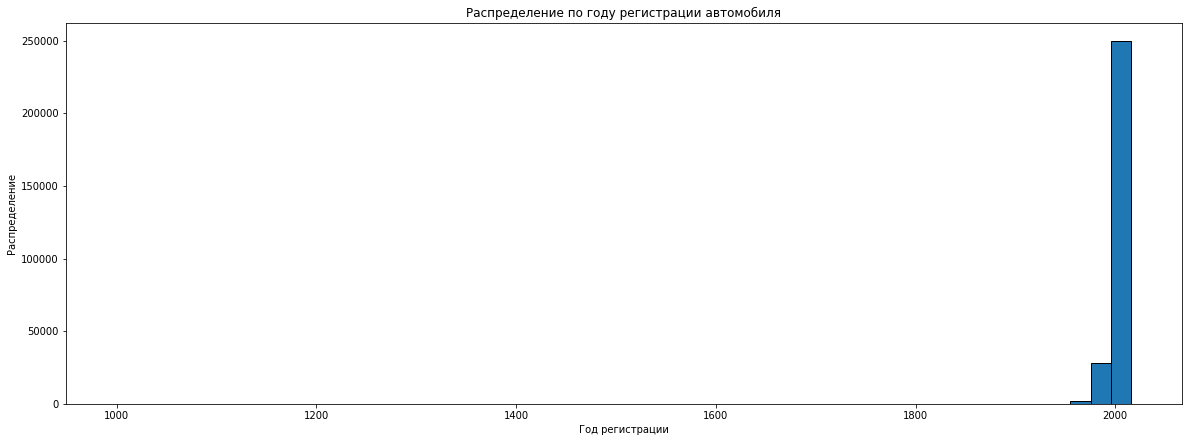

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['RegistrationYear'], bins=50, edgecolor='black', range=(1000, 2016))
plt.title('Распределение по году регистрации автомобиля')
plt.xlabel('Год регистрации')
plt.ylabel('Распределение')

plt.show()

Как и ожидалось, основная доля значений распределена в районе 2000-х годов, приблизительно c 1900-х

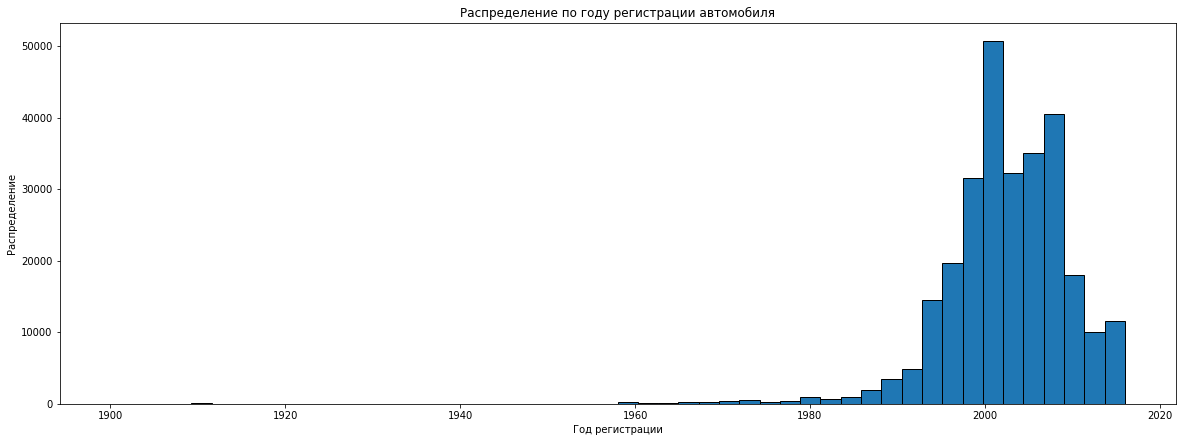

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['RegistrationYear'], bins=50, edgecolor='black', range=(1900, 2016))
plt.title('Распределение по году регистрации автомобиля')
plt.xlabel('Год регистрации')
plt.ylabel('Распределение')

plt.show()

Основная масса значений начинается с 1960 года, поэтому установим граници выборки с 1960 по 2016 годы

In [ ]:
# очистим данные от аномалий
data_autos = data_autos[(data_autos['RegistrationYear'] >= 1960) & (data_autos['RegistrationYear'] <= 2016)]

Изучим распределение мощности двигателя

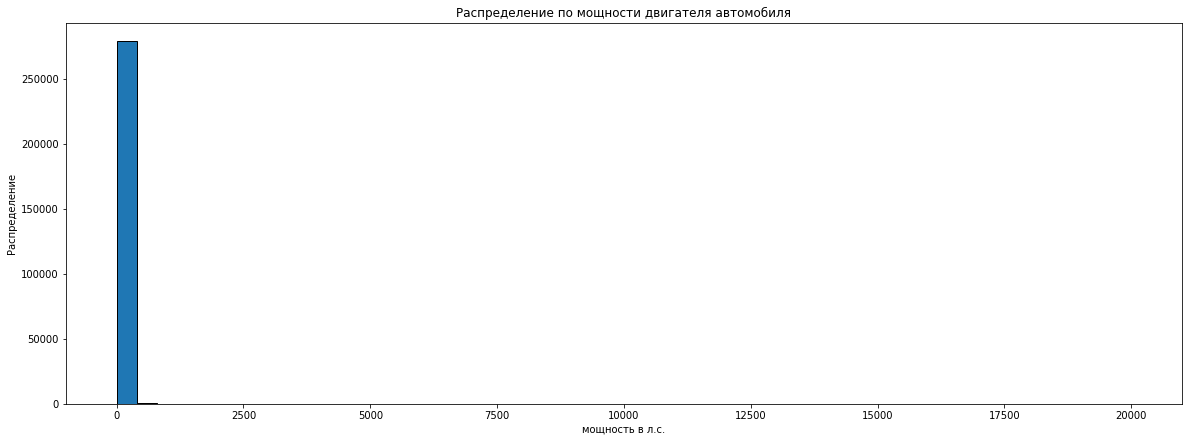

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Power'], bins=50, edgecolor='black')
plt.title('Распределение по мощности двигателя автомобиля')
plt.xlabel('мощность в л.с.')
plt.ylabel('Распределение')

plt.show()

Вполне ожидаемая история - основная масса значения сосредоточена где-то в районе до 1000 лошадиных сил, уменьшим масштаб наблюдения до 1000

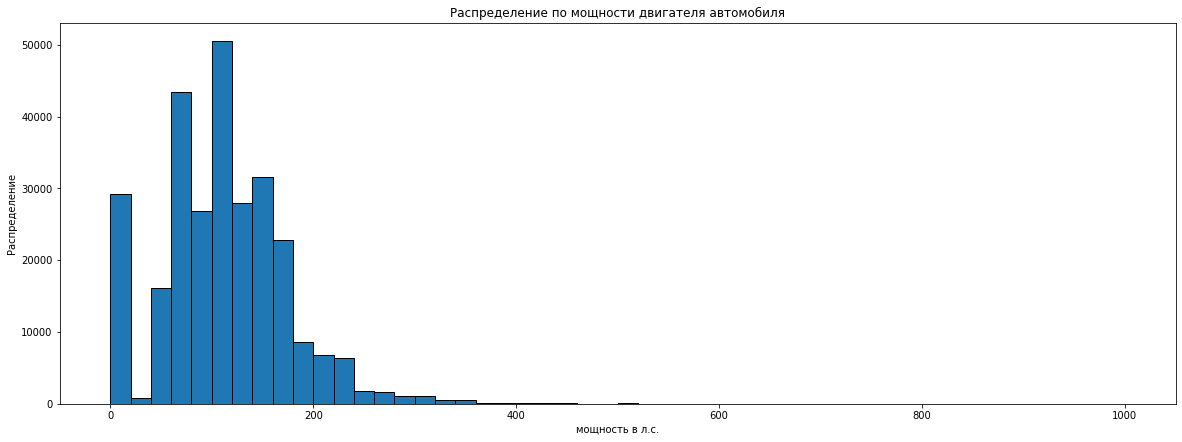

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Power'], bins=50, edgecolor='black', range=(0, 1000))
plt.title('Распределение по мощности двигателя автомобиля')
plt.xlabel('мощность в л.с.')
plt.ylabel('Распределение')

plt.show()

Последний пик у нас зафиксирован на отметке 500 ограничим им верхнюю границу

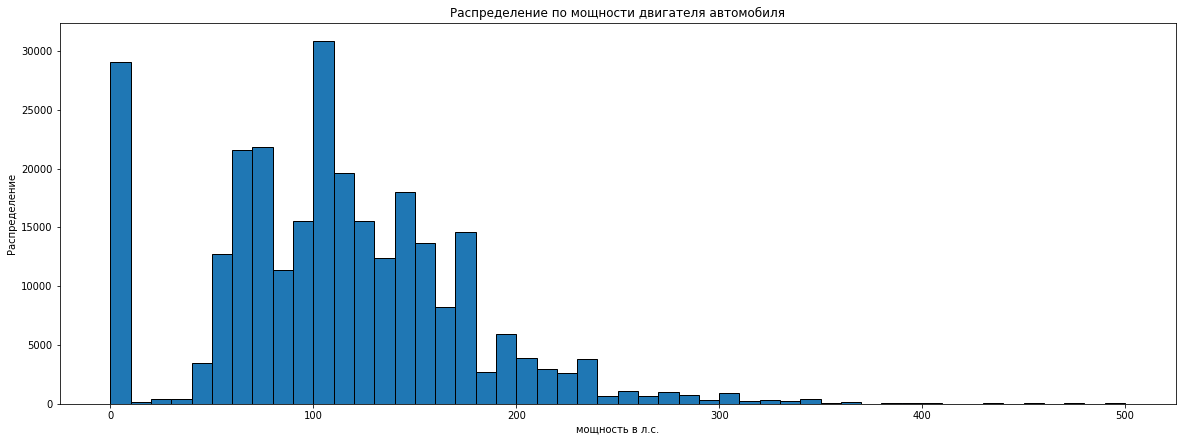

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Power'], bins=50, edgecolor='black', range=(0, 500))
plt.title('Распределение по мощности двигателя автомобиля')
plt.xlabel('мощность в л.с.')
plt.ylabel('Распределение')

plt.show()

Видим, что у нас большое количество 0 значений и аномально низких, уменьшим масштаб для определения нижней границы

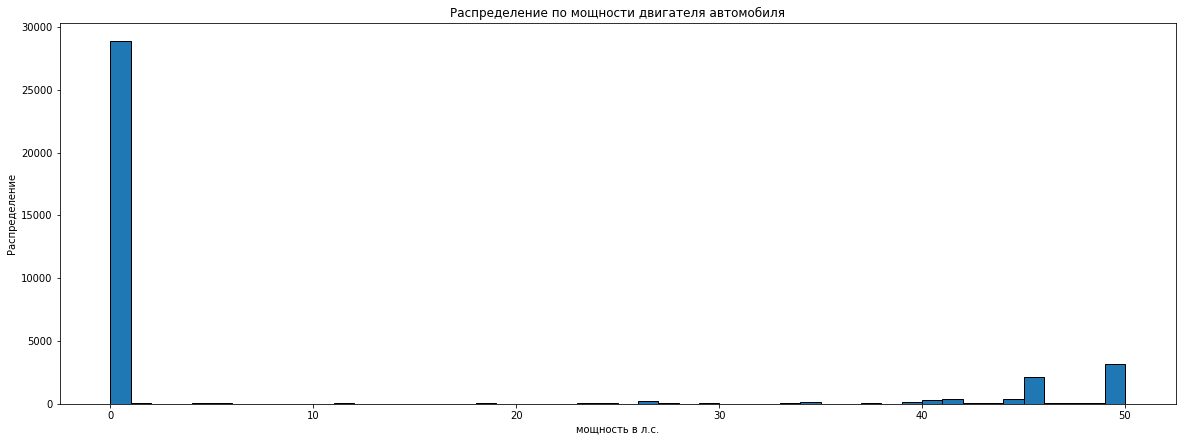

In [ ]:
plt.figure(figsize=(20,7))
plt.hist(data_autos['Power'], bins=50, edgecolor='black', range=(0, 50))
plt.title('Распределение по мощности двигателя автомобиля')
plt.xlabel('мощность в л.с.')
plt.ylabel('Распределение')

plt.show()

Относительно существенные результаты у нас начинаются от 40 л.с. их и установим нижней границей

In [ ]:
# очистим данные от аномалий
data_autos = data_autos[(data_autos['Power'] >= 40) & (data_autos['Power'] <= 500)]

:<div class="alert alert-block alert-warning">
<b>Комментарий:</b> В теории конечно могут быть машины с 0 мощностью, если машина битая и на запчасти продается, или двигатель уже сняли в качестве донора. Но, по большому счету, я, без двигателя, пока не встречал объявления, как раз наоборот, продавали лом с целым двигателем, чтобы двигатель использовать для донорства - двигатель самое ценное, что есть в авто, даже сломанный двигатель сложно демонтировать, обычно продают с ним. Так что, без подтверждения гипотезы исследованием, я бы не стал ее рассматривать как рабочую
</div>

**Шаг 9.** Приведем названия колонок к "змеиному" стилю

In [ ]:
# приведение стилистики к единой "змеиной"
data_autos.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in data_autos.columns]

**Шаг 10.** Проверка результатов предобработки

In [ ]:

data_autos = data_autos.reset_index(drop=True)
data_autos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248786 entries, 0 to 248785
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              248786 non-null  int64 
 1   vehicle_type       248786 non-null  object
 2   registration_year  248786 non-null  int64 
 3   gearbox            248786 non-null  object
 4   power              248786 non-null  int64 
 5   kilometer          248786 non-null  int64 
 6   fuel_type          248786 non-null  object
 7   repaired           248786 non-null  object
 8   model_auto         248786 non-null  object
dtypes: int64(4), object(5)
memory usage: 17.1+ MB


По итогу предобработки у нас осталось 249627 строк с 9 признаками, из которых один целевой и 8 входных.

#### Вывод по блоку

В результате предобработки данных:
- были заполнены пропуски данных
- удалены дубликаты строк
- сокращены диапазоны значений числовых данных, через удаление ошибочных аномальных крайних значений
- удалены неинформативные признаки
- признаки бренда и модели объединены в один
- стилистика приведена к "змеиной"

Теперь данные готовы к исследованию и обучению

### Корреляционный анализ данных

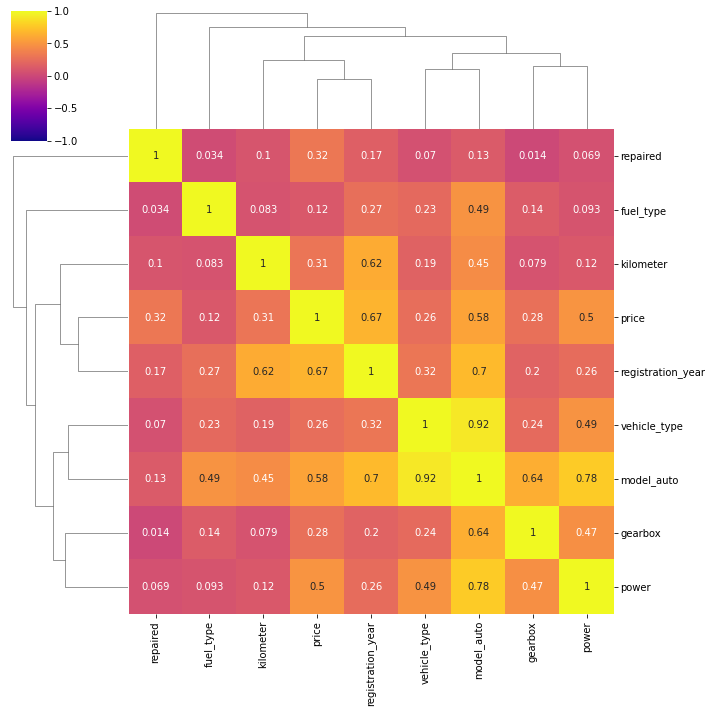

In [ ]:
# построим кластерную матрицу по итоговой таблице phik_matrix()
int_cols = ['price', 'power', 'kilometer']
sns.clustermap(
    data_autos.phik_matrix(interval_cols=int_cols),
    annot=True,
    vmin=-1,
    vmax=1,
    center=0,
    cmap='plasma')

In [ ]:
# выведем корреляции для числовых значений
data_autos.corr()

,price,registration_year,power,kilometer
price,1.000000,0.486733,0.495982,-0.378291
registration_year,0.486733,1.000000,0.102037,-0.305476
power,0.495982,0.102037,1.000000,0.119644
kilometer,-0.378291,-0.305476,0.119644,1.000000


Мультиколлинеарности между признаками не наблюдаем. При этом видно, что наибольшая корреляция с целевым признаком, у следующих входных признаков:
 - год регистрации автомобиля (по сути возраст)
 - модель автомобиля
 - мощность двигателя

Все остальные признаки хоть и имеют невысокую корреляцию с целевым признаком, однако она все равно существенная, все оставшиеся признаки имеют значение для определения цены

При оценке корреляции численных признаков, видно, что год регистрации и пробег имею прямую корреляцию с ценой авто, а пробег обратную. Это вполне очевидные факты: чем больше год (меньше возраст) и мощнее двгатель, тем дороже автомобиль, чем больше пробег, тем дешевле.

### Вывод

По итогу подгтовки данных для обучения:
- проведена загрузка данных для работы
- изучены загруженные данные, обнаружены ошибочные аномалии, пропуски, дубликаты как явные, так и не явные, установлено, что часть признаков являются неинформативными
- в ходе предобработки данных, с использованием графического анализа, заполнены пропуски, определены границы аномалий и данные от них очищены, удалены дубликаты, сокращено количество входных признаков, за счет удаления неинформативных и объединения связанных.
- при корреляционном анализе, установлена коррееляция между входными признаками и целевым, выявлены положительная и отрицательная корреляци между входными числовыми признаками и целевым

Полученные данные готовы для обучения моделей

## Обучение моделей

### Разделение и кодировка выборок

In [ ]:
# создадим копию датафрейма для кодировки категориальных данных
data_ohe = data_autos.copy()
data_ohe = pd.get_dummies(data_ohe)
# создадим копию датафрейма для переопределения типа категориальных данных
data_light = data_autos.copy()
data_light = data_light.astype({"vehicle_type":'category',
                                "gearbox":'category',
                                "model_auto":'category',
                                "fuel_type":'category',
                                "repaired":'category'})

# разделим выборки с входными и целевыми признаками для разных моделей
X = data_autos.drop('price',axis = 1)
y = data_autos['price']

X_ohe = data_ohe.drop('price',axis = 1)
y_ohe = data_ohe['price']

X_light = data_light.drop('price',axis = 1)
y_light = data_light['price']

In [ ]:
# для каждой выборки разделим тренировочные, валидационные и тестовые выборки
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size = 0.4,
    random_state = RANDOM_STATE
)

X_test, X_valid, y_test, y_valid = train_test_split(
    X_valid,
    y_valid,
    test_size = 0.5,
    random_state = RANDOM_STATE
)


X_train_ohe, X_valid_ohe, y_train_ohe, y_valid_ohe = train_test_split(
    X_ohe,
    y_ohe,
    test_size = 0.4,
    random_state = RANDOM_STATE
)

X_test_ohe, X_valid_ohe, y_test_ohe, y_valid_ohe = train_test_split(
    X_valid_ohe,
    y_valid_ohe,
    test_size = 0.5,
    random_state = RANDOM_STATE
)

X_train_light, X_valid_light, y_train_light, y_valid_light = train_test_split(
    X_light,
    y_light,
    test_size = 0.4,
    random_state = RANDOM_STATE
)

X_test_light, X_valid_light, y_test_light, y_valid_light = train_test_split(
    X_valid_light,
    y_valid_light,
    test_size = 0.5,
    random_state = RANDOM_STATE
)

### Обучение

Шаг 1. Проведем обучение модели градиентного бустинга

In [ ]:
# обучение CatBoostRegressor
start_time = time.time()

model_CBR = CatBoostRegressor(iterations=1000,
                              learning_rate=0.1,
                              depth=6,
                              loss_function='RMSE',
                              cat_features=['vehicle_type',
                                            'gearbox',
                                            'model_auto',
                                            'fuel_type',
                                            'repaired'],
                              random_state=RANDOM_STATE)

model_CBR.fit(X_train, y_train, eval_set=(X_valid, y_valid),
              verbose=100,
              early_stopping_rounds=50)

end_time = time.time()

training_time_CBR = end_time - start_time

# время обучения CatBoostRegressor
print('Время обучения CatBoostRegressor: %s секунд' % training_time_CBR)

# время предсказания CatBoostRegressor
start_time = time.time()
y_pred_CBR = model_CBR.predict(X_test)
end_time = time.time()
prediction_time_CBR = end_time - start_time
print('Время предсказания CatBoostRegressor на тестовой выборке: %s секунд' % prediction_time_CBR)

# оценка качества CatBoostRegressor на валидационной выборке
rmse_valid_CBR = mean_squared_error(y_valid, model_CBR.predict(X_valid), squared=False)
print('RMSE CatBoostRegressor на валидационной выборке: %.2f' % rmse_valid_CBR)

0:	learn: 4374.5648407	test: 4369.2502458	best: 4369.2502458 (0)	total: 261ms	remaining: 4m 20s
100:	learn: 1837.4605248	test: 1867.0020404	best: 1867.0020404 (100)	total: 13.4s	remaining: 1m 58s
200:	learn: 1763.3959408	test: 1802.1440899	best: 1802.1440899 (200)	total: 24.9s	remaining: 1m 39s
300:	learn: 1725.8219655	test: 1773.1143792	best: 1773.1143792 (300)	total: 36.7s	remaining: 1m 25s
400:	learn: 1701.9704241	test: 1756.5151961	best: 1756.5151961 (400)	total: 48.5s	remaining: 1m 12s
500:	learn: 1683.3963603	test: 1744.6389550	best: 1744.6389550 (500)	total: 1m 1s	remaining: 1m
600:	learn: 1665.3949843	test: 1733.4769350	best: 1733.4769350 (600)	total: 1m 13s	remaining: 49.1s
700:	learn: 1650.2473931	test: 1724.9669813	best: 1724.9153251 (699)	total: 1m 26s	remaining: 37s
800:	learn: 1636.1974239	test: 1717.5455791	best: 1717.5455791 (800)	total: 1m 39s	remaining: 24.7s
900:	learn: 1624.5497966	test: 1710.6557983	best: 1710.6557983 (900)	total: 1m 52s	remaining: 12.3s
999:	learn

На модели градиентного бустинга лучший результат по RMSE получен на последней итерации, при этом и время высокое.

In [ ]:
# обучение RandomForest
start_time = time.time()

model_RF = RandomForestRegressor(criterion = 'mse',
                                 n_estimators = 100,
                                 n_jobs=-1,
                                 random_state=RANDOM_STATE)

model_RF.fit(X_train_ohe, y_train_ohe)

end_time = time.time()

training_time_RF = end_time - start_time

# время обучения RandomForest
print('Время обучения RandomForest: %s секунд' % training_time_RF)

# время предсказания RandomForest
start_time = time.time()
y_pred_RF = model_RF.predict(X_test_ohe)
end_time = time.time()
prediction_time_RF = end_time - start_time
print('Время предсказания RandomForest на тестовой выборке: %s секунд' % prediction_time_RF)

# оценка качества RandomForest на валидационной выборке
rmse_valid_RF = mean_squared_error(y_valid_ohe, model_RF.predict(X_valid_ohe), squared=False)
print('RMSE RandomForest на валидационной выборке: %.2f' % rmse_valid_RF)

Время обучения RandomForest: 305.34057116508484 секунд
Время предсказания RandomForest на тестовой выборке: 2.9876389503479004 секунд
RMSE RandomForest на валидационной выборке: 1722.69


Модель "случайных лесов" показывает время обучения на медленнее и качество ниже. Можно поэкспериментировать с параметрами, но в любом случае при повышении скорости будет страдать качество и наоборот.

In [ ]:
# Обучение модели LightGBM
start_time = time.time()

cat_features = ['vehicle_type', 'gearbox', 'model_auto', 'fuel_type', 'repaired']
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'force_row_wise': True,
    'num_leaves': 50,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

lgb_train = lgb.Dataset(X_train_light, y_train_light, categorical_feature=cat_features)
lgb_valid = lgb.Dataset(X_valid_light, y_valid_light, categorical_feature=cat_features)
early_stopping_callback = lgb.early_stopping(stopping_rounds=100, verbose=100)

model_LGB = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      categorical_feature=cat_features,
                      valid_sets=[lgb_train, lgb_valid],
                      callbacks=[early_stopping_callback])

end_time = time.time()
training_time_LGB = end_time - start_time

# Время обучения модели LightGBM
print('Время обучения LightGBM: %s секунд' % training_time_LGB)

# Время предсказания модели LightGBM
start_time = time.time()
y_pred_LGB = model_LGB.predict(X_test_light)
end_time = time.time()
prediction_time_LGB = end_time - start_time
print('Время предсказания LightGBM: %s секунд' % prediction_time_LGB)

# Оценка качества модели LightGBM на валидационной выборке
rmse_valid_LGB = mean_squared_error(y_valid_light, model_LGB.predict(X_valid_light), squared=False)
print('RMSE LightGBM на валидационной выборке: %.2f' % rmse_valid_LGB)

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[743]	training's rmse: 1370.73	valid_1's rmse: 1618.64
Время обучения LightGBM: 58.67776894569397 секунд
Время предсказания LightGBM: 7.814514398574829 секунд
RMSE LightGBM на валидационной выборке: 1618.64


### Вывод
В блоке обучения моделей мы обучили три модели:
 - модель градиентного бустинга - CatBoostRegressor
 - модель случайных лесов - RandomForest
 - модель быстрого градиентного бустинга - LightGBM
 - по каждой модели определили оптимальные параметры времени предсказания как на валидационной, так и на тестовой выборках

## Анализ моделей

Для анализа соберем все результаты обучения в одну таблицу

In [ ]:
# запишем показатели качества по всем моделям в словарь
results = {'RMSE предсказания валидационный':[rmse_valid_CBR,
                                              rmse_valid_RF,
                                              rmse_valid_LGB],
           'Время обучения модели':[training_time_CBR,
                                    training_time_RF,
                                    training_time_LGB],
           'Время предсказания модели на тесте':[prediction_time_CBR,
                                                 prediction_time_RF,
                                                 prediction_time_LGB]
       }

# определим индексы будущего датафрейма
index = ['CatBoostRegressor',
         'RandomForest',
         'LightGBM'
        ]

# соберем датафрейм из словаря и индексов
results_data = pd.DataFrame(data=results, index=index)
results_data

,RMSE предсказания валидационный,Время обучения модели,Время предсказания модели на тесте
CatBoostRegressor,1707.271921,128.013298,0.471847
RandomForest,1722.691089,305.340571,2.987639
LightGBM,1618.643560,58.677769,7.814514


Итого, мы видим, что самые лучшие результаты не валидации и на тесте достигаются у модели LightGBM, однако у нее самое высокое время предсказания, хотя количество секунд не всегда критично.
Вместе с тем, самое высокое время предсказания у CatBoostRegressor, при средних показателях качества. Самое худшее качество у RandomForest.
Вместе с тем, все три модели показывают довольно высокое качество предсказания, по сравнению с условиями задания.

In [ ]:
# Оценка качества модели LightGBM на тестовой выборке

rmse_test = mean_squared_error(y_test_light, model_LGB.predict(X_test_light), squared=False)
print("RMSE LightGBM на тестовой выборке: %.2f" % rmse_test)

RMSE LightGBM на тестовой выборке: 1607.12


## Общий вывод

**Общий вывод**

По условиям задачи, необходимо было построить модель для определения рыночной стоимости подержанного автомобила на основании технических характеристиках и комплектации автомобиля
Для обучения модели были предоставлены данные о технических характеристиках, комплектации и ценах других автомобилей.

**Работа по этапов:**

1. Подготовка данных;
2. Обучение моделей;
3. Анализ моделей.


<h4>Подгтовка данных</h4>
При подгтовке данных для обучения:
 - проведена загрузка данных для работы
 - изучены загруженные данные, обнаружены ошибочные аномалии, пропуски, дубликаты как явные, так и не явные, установлено, что часть признаков являются неинформативными
 - в ходе предобработки данных, с использованием графического анализа, заполнены пропуски, определены границы аномалий и данные от них очищены, удалены дубликаты, сокращено количество входных признаков, за счет удаления неинформативных и объединения связанных
 - при корреляционном анализе, установлена корреляция между входными признаками и целевым, выявлены положительная и отрицательная корреляци между входными числовыми признаками и целевым, установлено отсутствие мультиколлинеарности между признаками

<h4>Обучение моделей</h4>
В блоке обучения моделей мы обучили три модели:
 - модель градиентного бустинга - CatBoostRegressor
 - модель случайных лесов - RandomForest
 - модель быстрого градиентного бустинга - LightGBM
 - по каждой модели определили оптимальные параметры времени предсказания как на валидационной, так и на тестовой выборках

<h4>Анализ моделей</h4>
По итогу анализа результатов моделей уствночлено,  самые лучшие результаты не валидации и на тесте достигаются у модели LightGBM, однако у нее самое высокое время предсказания на тесте, хотя 9 секунд не всегда критичное время. Вместе с тем, самое высокое время предсказания у CatBoostRegressor, при средних показателях качества. Самое худшее качество у RandomForest. Вместе с тем, все три модели показывают довольно высокое качество предсказания, по сравнению с условиями задания (меньше 2500).

<h4>Рекомендации</h4>

В ходе предобработки данных обнаружено большое количество пропусков в данных явно человеческого фактора.
Такие пропуски всегда связаны с необязательными пунктами.

Рекомендуется сбор данных от пользователей организовать следующим образом:
1. Составить справочник брендов и моделей с выделением возможных типов топлива, типов коробки, кузова для разных моделей, по умолчанию ввести выбор типов устанавливаемых заводских двигателей с соответстующими показателями мощности. Для историй с кастомным или "чужим" двигателем, не завдоской комплектации, ввести значение "иное" ("other").
2. Все вводимиые данные ограничить готовым набором параметров
3. Все вводимые параметры сделать обязательными, к выбору, без возможости пропусков значений.
4. Определить бинарные признаки (была в ремонте или нет) и ставить соответствующий бинарный выбор, без возможности указания иных выборов.
5. Ввести дополнительный бинарный признак "битая" / "не битая" или "в аварийном состоянии" / "на ходу"

Такой подход позволит осуществлять более чистый, незашумленный сбор информации о продаваемых автомобилях.